# Controller

In [1]:
# inspect controller with https://github.com/AppliedDataSciencePartners/WorldModels/blob/master/04_train_rnn.py

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import os

In [2]:
import sys
from pathlib import Path
path = str(Path(os.getcwd()).parent)
sys.path.insert(0, path)
from breakout.vae.vae import ConvVAE

import_path = str(Path(os.getcwd()).parent.parent)

sys.path.insert(0, import_path)

from WorldModelsExperiments.breakout.model import make_model, _process_frame

In [3]:
server= True
if server:   
    gamename ='breakout'
    optimizer = 'cma'
    num_episode = 16
    population = 6 # = num_workers * num_worker_trial
    
    file_path = path + '/breakout/results_200228/log_4000/'
    file_base = gamename+'.'+optimizer+'.'+str(num_episode)+'.'+str(population)
    
    vae_path = path + '/breakout/results_200228/tf_vae'
    rnn_path = path + '/breakout/results_200228/tf_rnn_10000'

In [4]:
model = make_model(rnn_path=os.path.join(rnn_path, 'rnn.json'), vae_path=os.path.join(vae_path, 'vae.json'))

/home/student/PycharmProjects/worldmodel/venv/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


INFO:tensorflow:Model using cpu.
model using cpu
input dropout mode = False
output dropout mode = False
recurrent dropout mode = False


In [5]:
model.load_model('/home/student/PycharmProjects/worldmodel/WorldModelsExperiments/breakout/log/breakout.cma.16.4.best.json')

loading file /home/student/PycharmProjects/worldmodel/WorldModelsExperiments/breakout/log/breakout.cma.16.4.best.json


In [6]:
model.weight.shape

(288, 3)

In [7]:
z_weight = model.weight[:32,]
z_weight.shape

(32, 3)

In [8]:
h_weight = model.weight[32:,]
h_weight.shape

(256, 3)

In [10]:
record_file = np.load('/home/student/PycharmProjects/worldmodel/WorldModelsExperiments/breakout/results_200228/record/1393908.npz')
obs_file = record_file['obs']
action_file = record_file['action']
reward_file = record_file['reward']
obs_file.shape

(400, 64, 64, 3)

In [11]:
action_file[0]

array([ 1.,  0.,  0.,  0.], dtype=float16)

In [12]:
mu, logvar = model.vae.encode_mu_logvar(obs_file)
mu.shape

(400, 32)

In [13]:
obs_file[0].shape

(64, 64, 3)

In [14]:
action_file[0]

array([ 1.,  0.,  0.,  0.], dtype=float16)

In [15]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    return random_value

In [16]:
def get_z_from_rnn_output(logmix, mean, logstd, z_dim=32,temperatur=1.0):
    chosen_log_pi = np.zeros(z_dim)
    chosen_mu = np.zeros(z_dim)
    chosen_log_sigma = np.zeros(z_dim)
        
    #adjust temp
    pi = np.copy(logmix) #/temperature
    logmix2 = np.exp(pi)
    logmix2 /= logmix2.sum(axis=1).reshape(z_dim, 1)
        
    for j in range(z_dim):
        idx = get_pi_idx(np.random.rand(), logmix2[j])
        chosen_log_pi[j] = idx
        chosen_mu[j] = mean[j, idx]
        chosen_log_sigma[j] = logstd[j,idx]
        
    rand_gaussian = np.random.randn(z_dim)*np.sqrt(temperatur)
    next_z = chosen_mu + np.exp(chosen_log_sigma) * rand_gaussian
    return next_z

In [45]:
obs_sequence = np.zeros(shape=(500,64,64,3))
total_reward = 0
appended_reward = []

initial_obs =model.env.reset()
# alternativ: get initial observation from env.reset() 
# and action from env.action_space.sample()

In [46]:
obs = obs_file[0]
state = model.state
index = 0
done = False

while not done:
    z = model.vae.encode(obs.reshape(1,64,64,3))

    action_one_hot = action_file[0]
    #action = np.array([0.,0.,0.,1.])

    input_x = np.concatenate((z.reshape((1, 1, 32)), action_one_hot.reshape((1, 1, 4))), axis=2)

    feed = {
        model.rnn.input_x: input_x,
        model.rnn.initial_state: state
        }
    [logmix, mean, logstd, next_state] = model.rnn.sess.run([
        model.rnn.out_logmix, model.rnn.out_mean, model.rnn.out_logstd, model.rnn.final_state],
        feed)
    next_z = get_z_from_rnn_output(logmix, mean, logstd)

    action_one_hot, action = model.get_action(next_z)

    obs, reward, done, info = model.env.step(action)

    total_reward += reward
    appended_reward.append(reward)

    obs = _process_frame(obs)

    obs_sequence[index,:,:,:] = obs

    state = next_state
    index+=1

In [37]:
done = False

In [32]:
obs_sequence[0].dtype

dtype('float64')

In [33]:
total_reward

0

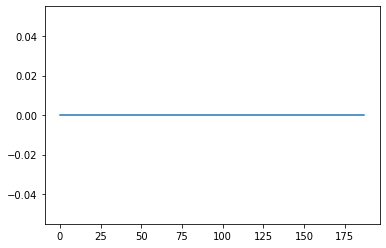

In [49]:
plt.plot(appended_reward)
plt.show()

## Video Sequence

In [42]:
import base64
import imageio
import IPython

In [43]:
def embed_mp4(filename,video):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [44]:
filename = 'controller_200228.mp4'
with imageio.get_writer(filename, mode='I') as video:    
    for image in range(len(obs_sequence)):
        video.append_data(np.array(obs_sequence[image]*255, dtype=np.uint8))
embed_mp4(filename,video)

# Train Param

In [50]:
with open(file_path+ file_base+ '.hist.json', 'r') as f:
    data = json.load(f)
#h = (t, curr_time, avg_reward, r_min, r_max, std_reward, int(es.rms_stdev()*100000)/100000., mean_time_step+1., int(max_time_step)+1)
data = np.array(data)
data.shape


(350, 9)

In [51]:
data_arr = []
for elem in data:
    data_arr.append([float(elem[2]), float(elem[3]), float(elem[4]), float(elem[5]), float(elem[6])])

In [52]:
required_score = 900.0
with open(file_path + file_base + '.hist_best.json', 'r') as f:
    raw_data = json.load(f)
raw_best_data = np.array(raw_data)
print(raw_best_data.shape)
best_data = []
for bdata in raw_best_data:
    best_data.append([float(bdata[0]), float(bdata[1]), float(bdata[5]), float(bdata[9])])
best_data = np.array(best_data)

(14, 10)


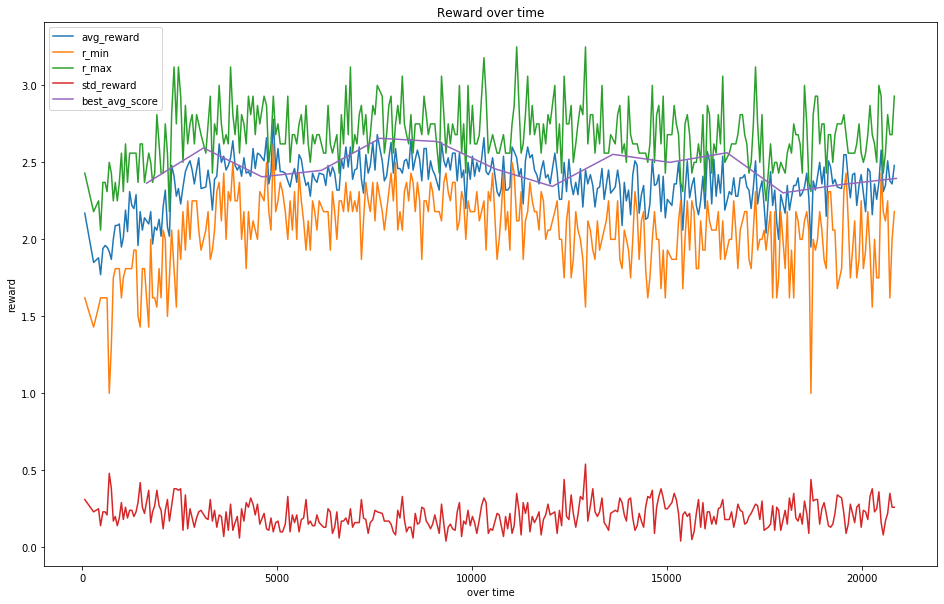

In [55]:
plt.figure(figsize=(16,10))
avg_r, = plt.plot(data[:,1], data[:,2])
min_r, = plt.plot(data[:,1], data[:,3])
max_r, = plt.plot(data[:,1], data[:,4])
std_r, = plt.plot(data[:,1], data[:,5])
best_r, = plt.plot(best_data[:,1], best_data[:,2])
plt.legend([avg_r, min_r, max_r, std_r, best_r], 
           ['avg_reward', 'r_min', 'r_max', 'std_reward', 'best_avg_score'])
plt.xlabel('over time')
plt.ylabel('reward')
plt.title('Reward over time')
plt.show()

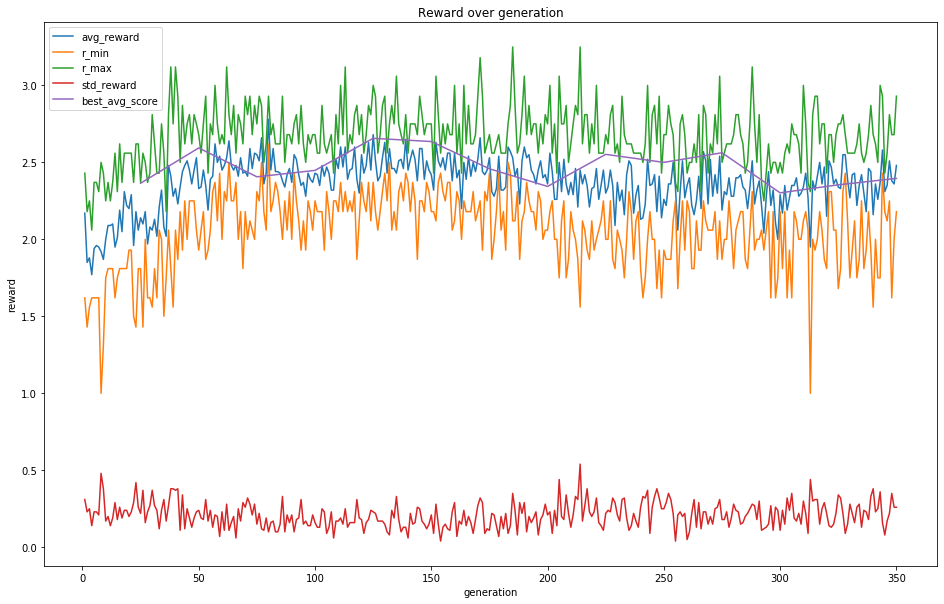

In [57]:
plt.figure(figsize=(16,10))
avg_r, = plt.plot(data[:,0], data[:,2])
min_r, = plt.plot(data[:,0], data[:,3])
max_r, = plt.plot(data[:,0], data[:,4])
std_r, = plt.plot(data[:,0], data[:,5])
best_r, = plt.plot(best_data[:,0], best_data[:,2])
plt.legend([avg_r, min_r, max_r, std_r, best_r], 
           ['avg_reward', 'r_min', 'r_max', 'std_reward', 'best_avg_score'])
plt.xlabel('generation')
plt.ylabel('reward')
plt.title('Reward over generation')
plt.show()